In [1]:
import os

#os.environ["MODIN_ENGINE"] = "ray"  # Modin will use Ray
#os.environ["MODIN_ENGINE"] = "dask"  # Modin will use Dask

import numpy as np # linear algebra
import pandas as pd

In [2]:
!pip install git+https://github.com/fastai/fastai2 
from fastai2.basics import *
from fastai2.callback.all import *
from fastai2.vision.all import *

  Cloning https://github.com/fastai/fastai2 to /tmp/pip-req-build-hessp9mg
  Running command git clone -q https://github.com/fastai/fastai2 /tmp/pip-req-build-hessp9mg
  Created wheel for fastai2: filename=fastai2-0.0.18-py3-none-any.whl size=193922 sha256=cc9db15e1549df3993f3f8d8f23708c005af096a1cc5bed939afe5f6008e1024
  Stored in directory: /tmp/pip-ephem-wheel-cache-tf4qv9oy/wheels/ae/82/02/6e3db8f92b8dfc6276971bcc29f1ae680f01603b98edb20c96
Successfully built fastai2


In [3]:
# train and test csv
train = pd.read_csv("../input/shopee-code-league-2020-product-detection/train.csv")
test = pd.read_csv("../input/shopee-code-league-2020-product-detection/test.csv")
# paths leading to images
train_path = Path("../input/shopee-code-league-2020-product-detection/resized/train")
test_path = Path("../input/shopee-code-league-2020-product-detection/resized/test")

In [4]:
# add the category to filename for easier usage with fastai API
train['filename'] = train.apply(lambda x: str(x.category).zfill(2) + '/' + x.filename, axis=1)
train

,filename,category
0,03/45e2d0c97f7bdf8cbf3594beb6fdcda0.jpg,3
1,03/f74d1a5fc2498bbbfa045c74e3cc333e.jpg,3
2,03/f6c172096818c5fab10ecae722840798.jpg,3
3,03/251ffd610399ac00fea7709c642676ee.jpg,3
4,03/73c7328b8eda399199fdedec6e4badaf.jpg,3
...,...,...
105387,25/047a60001de0331608ba64092cc7ae2b.jpg,25
105388,25/ea39ac66ccdc4b4d4c6443f6c54d8ae3.jpg,25
105389,25/6215f8c52c5bbcfe3e63e0f3ac6265f8.jpg,25
105390,25/1733d8286f6658149c7b7cdeb40d6461.jpg,25


In [5]:
# train in a 10% subset of the data
# to speed up experimentation
# comment these lines out to increase accuracy (but necessitates longer training time)
#from sklearn.model_selection import train_test_split
#_, train = train_test_split(train, test_size=0.1, stratify=train.category)

## Loading Data

We load the images easily using fastai2's API. We then crop and resize the image to 224x224 (the size the pre-trained model we will use was trained on) and then do some basic data augmentation and normalization (to ImageNet stats)

In [6]:
item_tfms = [RandomResizedCrop(299, min_scale=0.7,ratio=(1.,1.))]#,FlipItem(p=1.),DihedralItem(p=1.)]
batch_tfms = [*aug_transforms(), Normalize.from_stats(*imagenet_stats)]
def get_dls_from_df(df):
    df = df.copy()
    options = {
        "item_tfms": item_tfms,
        "batch_tfms": batch_tfms,
        "bs": 32,
    }
    dls = ImageDataLoaders.from_df(df, train_path, **options)
    return dls

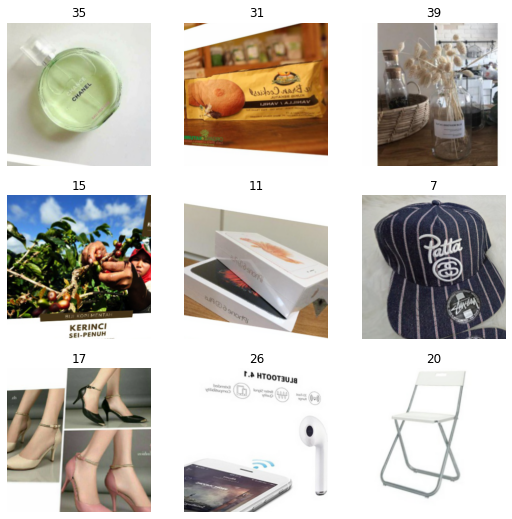

In [7]:
dls = get_dls_from_df(train)
dls.show_batch()

## Modeling, Training and Interpretation

In [8]:
!pip install timm

     |████████████████████████████████| 207 kB 3.5 MB/s eta 0:00:01


In [9]:
from timm import create_model

In [11]:
net = create_model('tf_efficientnet_b4_ns', pretrained=True)

Downloading: "https://github.com/rwightman/pytorch-image-models/releases/download/v0.1-weights/tf_efficientnet_b4_ns-d6313a46.pth" to /root/.cache/torch/checkpoints/tf_efficientnet_b4_ns-d6313a46.pth


In [12]:
learn = cnn_learner(dls, densenet161)

Downloading: "https://download.pytorch.org/models/densenet161-8d451a50.pth" to /root/.cache/torch/checkpoints/densenet161-8d451a50.pth


In [13]:
learn.model[-1]

Sequential(
  (0): AdaptiveConcatPool2d(
    (ap): AdaptiveAvgPool2d(output_size=1)
    (mp): AdaptiveMaxPool2d(output_size=1)
  )
  (1): Flatten(full=False)
  (2): BatchNorm1d(4416, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (3): Dropout(p=0.25, inplace=False)
  (4): Linear(in_features=4416, out_features=512, bias=False)
  (5): ReLU(inplace=True)
  (6): BatchNorm1d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (7): Dropout(p=0.5, inplace=False)
  (8): Linear(in_features=512, out_features=42, bias=False)
)

In [14]:
create_head(4416, 42)

Sequential(
  (0): AdaptiveConcatPool2d(
    (ap): AdaptiveAvgPool2d(output_size=1)
    (mp): AdaptiveMaxPool2d(output_size=1)
  )
  (1): Flatten(full=False)
  (2): BatchNorm1d(4416, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (3): Dropout(p=0.25, inplace=False)
  (4): Linear(in_features=4416, out_features=512, bias=False)
  (5): ReLU(inplace=True)
  (6): BatchNorm1d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (7): Dropout(p=0.5, inplace=False)
  (8): Linear(in_features=512, out_features=42, bias=False)
)

In [15]:
net

EfficientNet(
  (conv_stem): Conv2dSame(3, 48, kernel_size=(3, 3), stride=(2, 2), bias=False)
  (bn1): BatchNorm2d(48, eps=0.001, momentum=0.1, affine=True, track_running_stats=True)
  (act1): SwishMe()
  (blocks): Sequential(
    (0): Sequential(
      (0): DepthwiseSeparableConv(
        (conv_dw): Conv2d(48, 48, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), groups=48, bias=False)
        (bn1): BatchNorm2d(48, eps=0.001, momentum=0.1, affine=True, track_running_stats=True)
        (act1): SwishMe()
        (se): SqueezeExcite(
          (avg_pool): AdaptiveAvgPool2d(output_size=1)
          (conv_reduce): Conv2d(48, 12, kernel_size=(1, 1), stride=(1, 1))
          (act1): SwishMe()
          (conv_expand): Conv2d(12, 48, kernel_size=(1, 1), stride=(1, 1))
        )
        (conv_pw): Conv2d(48, 24, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (bn2): BatchNorm2d(24, eps=0.001, momentum=0.1, affine=True, track_running_stats=True)
        (act2): Identity()
      )
     

In [16]:
def create_body(arch, pretrained=True, cut=None):
    "Cut off the body of a typically pretrained `arch` as determined by `cut`"
    model = arch(pretrained=pretrained)
    #cut = ifnone(cut, cnn_config(arch)['cut'])
    if cut is None:
        ll = list(enumerate(model.children()))
        cut = next(i for i,o in reversed(ll) if has_pool_type(o))
    if   isinstance(cut, int): return nn.Sequential(*list(model.children())[:cut])
    elif callable(cut): return cut(model)
    else: raise NamedError("cut must be either integer or a function")

In [17]:
def create_timm_body(arch:str, pretrained=True, cut=None):
  model = create_model(arch, pretrained=pretrained)
  if cut is None:
    ll = list(enumerate(model.children()))
    cut = next(i for i,o in reversed(ll) if has_pool_type(o))
  if isinstance(cut, int): return nn.Sequential(*list(model.children())[:cut])
  elif callable(cut): return cut(model)
  else: raise NamedError("cut must be either integer or function")

In [18]:
body = create_timm_body('tf_efficientnet_b4_ns', pretrained=True)

In [20]:
body

Sequential(
  (0): Conv2dSame(3, 48, kernel_size=(3, 3), stride=(2, 2), bias=False)
  (1): BatchNorm2d(48, eps=0.001, momentum=0.1, affine=True, track_running_stats=True)
  (2): SwishMe()
  (3): Sequential(
    (0): Sequential(
      (0): DepthwiseSeparableConv(
        (conv_dw): Conv2d(48, 48, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), groups=48, bias=False)
        (bn1): BatchNorm2d(48, eps=0.001, momentum=0.1, affine=True, track_running_stats=True)
        (act1): SwishMe()
        (se): SqueezeExcite(
          (avg_pool): AdaptiveAvgPool2d(output_size=1)
          (conv_reduce): Conv2d(48, 12, kernel_size=(1, 1), stride=(1, 1))
          (act1): SwishMe()
          (conv_expand): Conv2d(12, 48, kernel_size=(1, 1), stride=(1, 1))
        )
        (conv_pw): Conv2d(48, 24, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (bn2): BatchNorm2d(24, eps=0.001, momentum=0.1, affine=True, track_running_stats=True)
        (act2): Identity()
      )
      (1): DepthwiseSepar

In [19]:
nf = num_features_model(nn.Sequential(*body.children())) * (2); 
nf

3584

In [20]:
head = create_head(nf, dls.c)

In [21]:
head

Sequential(
  (0): AdaptiveConcatPool2d(
    (ap): AdaptiveAvgPool2d(output_size=1)
    (mp): AdaptiveMaxPool2d(output_size=1)
  )
  (1): Flatten(full=False)
  (2): BatchNorm1d(3584, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (3): Dropout(p=0.25, inplace=False)
  (4): Linear(in_features=3584, out_features=512, bias=False)
  (5): ReLU(inplace=True)
  (6): BatchNorm1d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (7): Dropout(p=0.5, inplace=False)
  (8): Linear(in_features=512, out_features=42, bias=False)
)

In [22]:
model = nn.Sequential(body, head)
model

Sequential(
  (0): Sequential(
    (0): Conv2dSame(3, 48, kernel_size=(3, 3), stride=(2, 2), bias=False)
    (1): BatchNorm2d(48, eps=0.001, momentum=0.1, affine=True, track_running_stats=True)
    (2): SwishMe()
    (3): Sequential(
      (0): Sequential(
        (0): DepthwiseSeparableConv(
          (conv_dw): Conv2d(48, 48, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), groups=48, bias=False)
          (bn1): BatchNorm2d(48, eps=0.001, momentum=0.1, affine=True, track_running_stats=True)
          (act1): SwishMe()
          (se): SqueezeExcite(
            (avg_pool): AdaptiveAvgPool2d(output_size=1)
            (conv_reduce): Conv2d(48, 12, kernel_size=(1, 1), stride=(1, 1))
            (act1): SwishMe()
            (conv_expand): Conv2d(12, 48, kernel_size=(1, 1), stride=(1, 1))
          )
          (conv_pw): Conv2d(48, 24, kernel_size=(1, 1), stride=(1, 1), bias=False)
          (bn2): BatchNorm2d(24, eps=0.001, momentum=0.1, affine=True, track_running_stats=True)
       

In [23]:
apply_init(model[1], nn.init.kaiming_normal_)

In [24]:
learn = Learner(dls, model, loss_func=LabelSmoothingCrossEntropy())
learn.summary()

Sequential (Input shape: ['32 x 3 x 299 x 299'])
Layer (type)         Output Shape         Param #    Trainable 
Conv2dSame           32 x 48 x 150 x 150  1,296      True      
________________________________________________________________
BatchNorm2d          32 x 48 x 150 x 150  96         True      
________________________________________________________________
SwishMe              32 x 48 x 150 x 150  0          False     
________________________________________________________________
Conv2d               32 x 48 x 150 x 150  432        True      
________________________________________________________________
BatchNorm2d          32 x 48 x 150 x 150  96         True      
________________________________________________________________
SwishMe              32 x 48 x 150 x 150  0          False     
________________________________________________________________
AdaptiveAvgPool2d    32 x 48 x 1 x 1      0          False     
_________________________________________________

In [25]:
learn = Learner(dls, model, loss_func=LabelSmoothingCrossEntropy(), 
                splitter=default_split, metrics=error_rate)

In [26]:
#total trainable param
learn.freeze()
learn.summary()

Sequential (Input shape: ['32 x 3 x 299 x 299'])
Layer (type)         Output Shape         Param #    Trainable 
Conv2dSame           32 x 48 x 150 x 150  1,296      False     
________________________________________________________________
BatchNorm2d          32 x 48 x 150 x 150  96         True      
________________________________________________________________
SwishMe              32 x 48 x 150 x 150  0          False     
________________________________________________________________
Conv2d               32 x 48 x 150 x 150  432        False     
________________________________________________________________
BatchNorm2d          32 x 48 x 150 x 150  96         True      
________________________________________________________________
SwishMe              32 x 48 x 150 x 150  0          False     
________________________________________________________________
AdaptiveAvgPool2d    32 x 48 x 1 x 1      0          False     
_________________________________________________

In [27]:
learn.fine_tune(7)

epoch,train_loss,valid_loss,error_rate,time
0,1.936649,1.641743,0.303065,25:13


epoch,train_loss,valid_loss,error_rate,time
0,1.669727,1.470411,0.248600,33:21
1,1.518681,1.381198,0.225021,33:14
2,1.435308,1.319800,0.204052,33:10
3,1.332467,1.290992,0.193140,33:08
4,1.318212,1.268091,0.186023,33:07
5,1.265322,1.261226,0.184126,33:04
6,1.256084,1.260222,0.183794,33:31


In [28]:
learn.model_dir='/kaggle/working/'
learn.save('stage-1')

SuggestedLRs(lr_min=6.309573450380412e-08, lr_steep=2.75422871709452e-06)

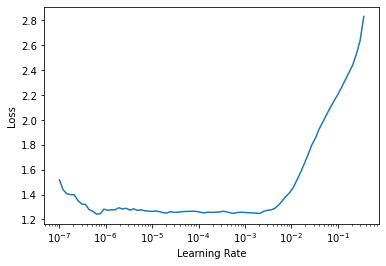

In [30]:
learn.unfreeze()
learn.lr_find()

In [31]:
learn.fit_one_cycle(5, 1e-4)

epoch,train_loss,valid_loss,error_rate,time
0,1.288903,1.257591,0.184221,33:32
1,1.226189,1.229092,0.174447,33:11
2,1.130698,1.217073,0.168802,33:07
3,0.994886,1.218730,0.167046,33:09
4,0.947798,1.229282,0.166999,33:09


SuggestedLRs(lr_min=1.9054607491852948e-07, lr_steep=7.585775847473997e-07)

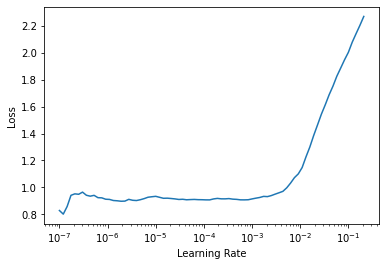

In [39]:
learn.unfreeze()
learn.lr_find()

In [40]:
learn.fit_one_cycle(2, 1e-4)

epoch,train_loss,valid_loss,error_rate,time
0,1.047223,1.247939,0.174779,33:04
1,0.926072,1.244404,0.170604,33:06


In [ ]:
# got LB 0.79044 with 8 epoch efficientnet_3
# got LB 0.78901 with 15 epoch efficientnet_3
# my best public leaderboard 0.79
#!pip install efficientnet_pytorch

In [ ]:
"""
from efficientnet_pytorch import EfficientNet
model_name = 'efficientnet-b3'
def get_model(pretrained=True, **kwargs):
    model = EfficientNet.from_pretrained(model_name)
    #model = EfficientNet.from_name(model_name)
    model._fc = nn.Linear(model._fc.in_features, dls.c)
    return model
"""

In [ ]:
"""
learn = Learner(dls, get_model(), 
                metrics=[error_rate, accuracy],
                callback_fns=[partial(SaveModelCallback)],
                wd=0.1,
                path = '.')
"""

In [ ]:
#learn.fine_tune(18,1e-3)

In [ ]:
learn.model_dir='/kaggle/working/'
learn.save('stage-1')

In [ ]:
learn.load('stage-1')

Plot confusion matrix to see how well our model classify specific categories.

## Predictions

In [41]:
test_images = test.filename.apply(lambda fn: test_path/fn)
test_dl = dls.test_dl(test_images)

In [42]:
preds = learn.get_preds(dl=test_dl, with_decoded=True)
preds

(tensor([[0.0021, 0.0017, 0.0030,  ..., 0.0055, 0.0009, 0.1211],
         [0.0037, 0.0034, 0.0025,  ..., 0.0021, 0.0017, 0.0020],
         [0.0067, 0.0027, 0.0049,  ..., 0.0053, 0.0008, 0.0034],
         ...,
         [0.0036, 0.0045, 0.0032,  ..., 0.0127, 0.0044, 0.0041],
         [0.0056, 0.0038, 0.0035,  ..., 0.0046, 0.0038, 0.0037],
         [0.0040, 0.0065, 0.0051,  ..., 0.0160, 0.0098, 0.0050]]),
 None,
 tensor([20, 27,  4,  ..., 13, 15, 23]))

* preds[0] -> probabilities
* preds[1] -> ground truth (None in this case as we are training on the test set)
* preds[2] -> decoded probabilities AKA our category/label predictions

In [34]:
# save raw predictions
torch.save(preds, "rawpreds")

## Submission

In [43]:
submission  = test[["filename"]]
submission["category"] = preds[2]

We need to then zero-pad the submissions ('01' instead of '1').

In [44]:
# zero-pad the submissions
submission["category"] = submission.category.apply(lambda c: str(c).zfill(2))

In [45]:
# preview
submission

,filename,category
0,fd663cf2b6e1d7b02938c6aaae0a32d2.jpg,20
1,c7fd77508a8c355eaab0d4e10efd6b15.jpg,27
2,127f3e6d6e3491b2459812353f33a913.jpg,04
3,5ca4f2da11eda083064e6c36f37eeb81.jpg,22
4,46d681a542f2c71be017eef6aae23313.jpg,12
...,...,...
12181,5ba958eacb23cd7d1673bad4dae55784.jpg,16
12182,efbe41a1c2b666b70e337e438559808b.jpg,19
12183,79fdaa5ac5ba10dbe8004cabd8c35eb3.jpg,13
12184,ac3d136124617637a05ba66694e381ef.jpg,15


In [ ]:
# save the submissions as CSV
#submission.to_csv("submission.csv",index=False)

In [38]:
submission.to_csv("0.8294_7+5+2_epoch_efficientnet_b4_ns.csv",index=False)
#submission.to_csv("output_14_epoch_retake.csv",index=False)
#submission.to_csv("output_14_epoch_label_smoothing.csv",index=False)